# Analysing NYC High School Data

This project we will explore the relationship between SAT scores and demographic factors in New York City public schools. For a brief bit of background, the SAT, or Scholastic Aptitude Test, is a test that high school seniors in the U.S. take every year. The SAT has three sections, each of which is worth a maximum of 800 points. Colleges use the SAT to determine which students to admit. High average SAT scores are usually indicative of a good school.

New York City has published data on student SAT scores by high school, along with additional demographic data sets. Datasets we will use are:

- [SAT scores by school](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4) - SAT scores for each high school in New York City
- [School attendance](https://data.cityofnewyork.us/Education/2010-2011-School-Attendance-and-Enrollment-Statist/7z8d-msnt) - Attendance information for each school in New York City
- [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school
- [AP test results](https://data.cityofnewyork.us/Education/2010-AP-College-Board-School-Level-Results/itfs-ms3e) - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
- [Graduation outcomes]( - The percentage of students who graduated, and other outcome information
- Demographics - Demographic information for each school
- School survey - Surveys of parents, teachers, and students at each school

New York City has a significant immigrant population and is very diverse, so comparing demographic factors such as race, income, and gender with SAT scores is a good way to determine whether the SAT is a fair test. For example, if certain racial groups consistently perform better on the SAT, we would have some evidence that the SAT is unfair.

## Read in the data

We start by reading in the various datasets and storing them all together in a dictionary for easy access.

In [14]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

## Read in the surveys

The more complex survey files are now imported, with the specific encodings and delimiters. The excess columns are filtered from almost 2000 down to less than 30. 

In [15]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

## Add DBN columns

We capitalise the columns named 'dbn' to match the other datasets. For datasets that do not have this column, it is created by concatenating the data from the CSD and School Code columns.

In [16]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

## Convert columns to numeric

Start by converting the specific SAT results from string to numeric values, and add a total column containing the sum of these. 

Also, write functions to extract the longitude and latitude of the school from the Location column in 'hs_directory'. These are also converted to numeric values and saved to specific columns. 

In [17]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

## Condense datasets

Filter the 'class_size' dataset by grade and program type to retrieve the relevant general high school data. 

From 'demographics', pick out the school year for 2011-2012. 

For the 'graduation' dataset, filter the latest cohort of 2006, and only include data relevant to the Total Cohort. 

In [18]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

## Convert AP scores to numeric

Convert the following three columns to numeric data to allow further processing.

In [19]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

## Combine the datasets

Following the specific filtering and cleaning, we finally combining the various datasets by merging the rows on the 'DBN' column key. 

We use specific order of joins to minimise the data loss.

In [20]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

## Add a school district column for mapping

Here we extract the school district from the 'DBN' column and store it in a new column. 

In [21]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## Find correlations

Calculate the Pearson Correlation Coefficient between 'sat_score' and other columns. 

In [22]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

## Plotting survey correlations

Remove DBN since it's a unique identifier, not a useful numerical value for correlation.

In [23]:
survey_fields.remove("DBN")

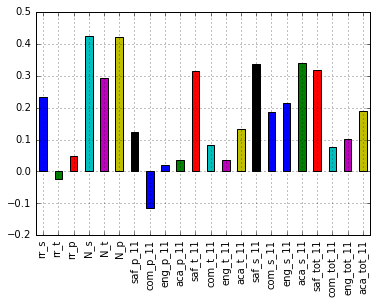

In [24]:
correlations[survey_fields].plot(kind='bar', grid=True)

Two of the columns 'saf_t_11' and 'saf_s_11', which measure how teachers and students perceive safety at school, correlated highly with 'sat_score'.

## Exploring safety and SAT scores

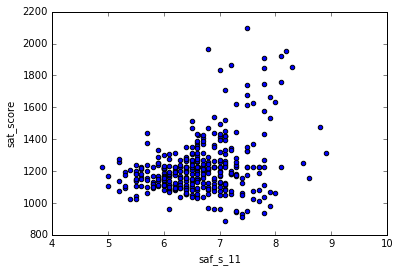

In [25]:
combined.plot.scatter(x='saf_s_11', y='sat_score')

From this scatter plot, the positive correlation between safety and SAT scores is further supported. 

In [26]:
grouped = combined.groupby('school_dist')
districts = grouped.aggregate(np.mean)
districts.reset_index(inplace=True)
districts.head()

,school_dist,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
0,01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,1.0,...,12.0,12.0,10003.166667,659.500000,1.333333,0.0,0.0,0.0,40.719022,-73.982377
1,02,426.619092,444.186256,424.832836,1295.638184,128.908454,201.516827,157.495833,158.647849,2.0,...,12.0,12.0,10023.770833,621.395833,1.416667,0.0,0.0,0.0,40.739699,-73.991386
2,03,428.529851,437.997512,426.915672,1293.443035,156.183494,244.522436,193.087500,183.384409,3.0,...,12.0,12.0,10023.750000,717.916667,2.000000,0.0,0.0,0.0,40.781574,-73.977370
3,04,402.142857,416.285714,405.714286,1224.142857,129.016484,183.879121,151.035714,113.857143,4.0,...,12.0,12.0,10029.857143,580.857143,1.142857,0.0,0.0,0.0,40.793449,-73.943215
4,05,427.159915,438.236674,419.666098,1285.062687,85.722527,115.725275,142.464286,143.677419,5.0,...,12.0,12.0,10030.142857,609.857143,1.142857,0.0,0.0,0.0,40.817077,-73.949251


Start by grouping the 'combined' dataframe by the district and aggragating the data to find the means, which can then be used to plot the map.

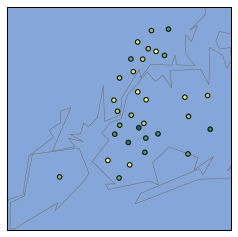

In [27]:
from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()
m.scatter(longitudes, latitudes, s=20, zorder=2, latlon=True, c=districts['saf_s_11'], cmap='summer')
plt.show()

The plotted map shows the average safety score in every NYC district with each plotted point representing a district. Yellow shading indicates schools with a high 'safety' value, and green shading indicates schools with a low 'safety' vlaues. 

## Exploring race and SAT scores

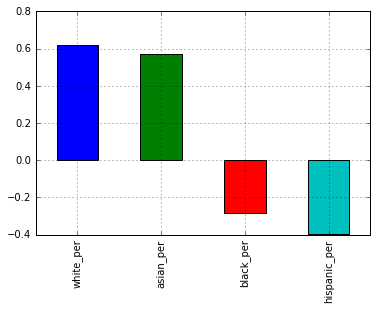

In [28]:
race_cols = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
correlations[race_cols].plot(kind='bar', grid=True)

This plot shows strong relations between race and SAT scores. There is a clear positive correlation with White and Asian heavy schools, and a negative correlation with Black and Hispanic races. 

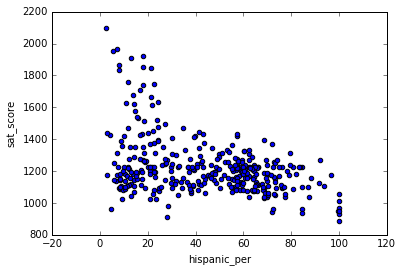

In [29]:
combined.plot.scatter(x='hispanic_per', y='sat_score')

This shows a negative correlation between Hispanic percentage of students and SAT score. The correlation seems to be dampened slightly by the large grouping of schools with low SAT scores regardless of Hispanic students. 

In [33]:
combined.loc[combined['hispanic_per'] > 95, 'SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The schools identified here have over 95% of their students of Hispanic descent. Through some further research we see that these schools are all largely international schools serving students that do not speak english, and have lived in USA for less than four years. 

In [39]:
combined.loc[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800), 'SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The schools identified here with less than 10% of Hispanic students and SAT scores higher than 1800 are all specialised high schools, and college preparatory schools. 

## Exploring gender and SAT scores

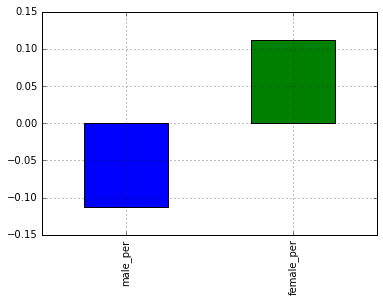

In [35]:
gender_cols = ['male_per', 'female_per']
correlations[gender_cols].plot(kind='bar', grid=True)

From this plot it is clear there is a slight negative correlation with male percentage and positive correlation with female percentage. This suggests that girls generally perform better on SATs than boys. 

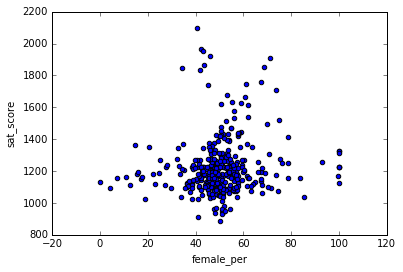

In [36]:
combined.plot.scatter(x='female_per', y='sat_score')

From this general scatter plot it is difficult to identify a pattern, due to the large cluster of results around the 50% mark. Therefore let us try plotting just the higher values. 

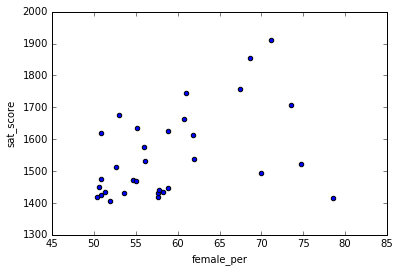

In [41]:
temp = combined[(combined['female_per'] > 50) & (combined['sat_score'] > 1400)]
temp.plot.scatter(x='female_per', y='sat_score')

Filtering by data points with female percentages higher than 50% and SAT scores over 1400, we start to see the slight correlation. It is still not a strong relation, however is starting to become visible. 

In [42]:
combined.loc[(combined['female_per'] > 60) & (combined['sat_score'] > 1700), 'SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Each of these schools with high percentage of female students and high SAT scores all seem to have some features making the school unique. Some are alternative schools offering a curriculum differing from the standard state education, some are much smaller suggesting extra specific attention to each student, while others are specialised, technical college prep schools.

## Exploring AP scores vs. SAT scores

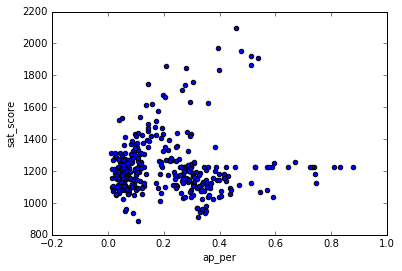

In [45]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']
combined.plot.scatter(x='ap_per', y='sat_score')

Comparing the percentage of AP test takers and SAT scores shows a strong positive correlation when looking at the higher SAT scores. There also seems to be a sort of common SAT score of just over 1200, which is common over all percentages of AP test takers. This indicates some data for the SAT scores may have been averaged and assigned to the empty values. 

## Next steps...

Here are some potential next steps:

- Determing wheter there's a correlation between class size and SAT scores
- Figuring out which neighborhoods have the best schools
    - If we combine this information with a dataset containing property values, we could find the least expensive neighborhoods that have good schools.
- Investigating the differences between parent, teacher, and student responses to surveys.
- Assigning scores to schools based on sat_score and other attributes.